In [ ]:
!conda install -y gdown

/bin/bash: conda: command not found


In [1]:
!gdown "1wW-PTHoyVam7YtbDTy-pDGa5ghrajLnr"

Downloading...
From: https://drive.google.com/uc?id=1wW-PTHoyVam7YtbDTy-pDGa5ghrajLnr
To: /content/states_dataset_2.1.zip
100% 1.38G/1.38G [00:08<00:00, 166MB/s]


In [2]:
%%capture --no-display
!unzip states_dataset_2.1.zip

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.callbacks import EarlyStopping , ModelCheckpoint , LearningRateScheduler, ReduceLROnPlateau
import gc

In [4]:
os.listdir()

['.config',
 'valid',
 'states_dataset_2.1.zip',
 '__MACOSX',
 'train',
 'sample_data']

In [5]:
train_path = "train"
test_path = "valid"
labels = [f for f in os.listdir(train_path) if not f.startswith('.')]
labels

['jullienne',
 'whole',
 'diced',
 'floured',
 'grated',
 'peeled',
 'sliced',
 'mixed',
 'other',
 'juiced',
 'creamy_paste']

In [6]:
label_map = {k:v for v,k in enumerate(labels)}
label_map

{'jullienne': 0,
 'whole': 1,
 'diced': 2,
 'floured': 3,
 'grated': 4,
 'peeled': 5,
 'sliced': 6,
 'mixed': 7,
 'other': 8,
 'juiced': 9,
 'creamy_paste': 10}

In [7]:
def get_data(path,labels): 
  data_dict = {"images":[], "labels":[]}
  for label in labels:
    inner_path = os.path.join(path,label)
    for item in os.listdir(inner_path):
      data_dict['images'].append(os.path.join(inner_path,item))
      data_dict['labels'].append(label_map[label])
  return pd.DataFrame(data_dict).sample(frac=1)

In [8]:
train_data = get_data(train_path,labels)
test_data = get_data(test_path,labels)
# display first 5 rows
train_data.head()

,images,labels
5025,train/sliced/0702.jpg,6
4154,train/peeled/0003.jpg,5
3910,train/peeled/0063.jpg,5
2759,train/floured/0451.jpg,3
4704,train/sliced/54.depositphotos_23945061-stock-p...,6


In [9]:
train_data['labels'].value_counts()

6     1122
1      932
2      898
9      881
8      873
10     757
4      696
7      677
0      607
3      582
5      558
Name: labels, dtype: int64

In [10]:
IMG_SIZE = 128
train_images = []
for path in tqdm(train_data['images']):
  img = cv2.imread(path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  train_images.append(img)

100%|██████████| 8583/8583 [01:00<00:00, 141.46it/s]


In [11]:
test_images = []
for path in tqdm(test_data['images']):
  img = cv2.imread(path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  test_images.append(img)

100%|██████████| 1912/1912 [00:12<00:00, 156.19it/s]


In [12]:
x_train=np.asarray(train_images) / 255.0
y_train = np.asarray(train_data['labels'])

In [13]:
gc.collect()
del train_data

In [14]:
x_test=np.asarray(test_images) / 255.0
y_test = np.asarray(test_data['labels'])

In [15]:
del test_data
gc.collect()

0

In [16]:
print(f"X train Shape is {x_train.shape}")
print(f"Y train Shape is {y_train.shape}")
print(f"X Test Shape is {x_test.shape}")
print(f"Y test Shape is {y_test.shape}")

X train Shape is (8583, 128, 128, 3)
Y train Shape is (8583,)
X Test Shape is (1912, 128, 128, 3)
Y test Shape is (1912,)


In [17]:
del train_images,test_images

In [18]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(shape=input_shape)

# Convolutional layers with Inception module and residual connections

conv1 = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
bn1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(bn1)

conv5_1 = Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(pool1)
bn5_1 = BatchNormalization()(conv5_1)
conv5_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
bn5_2 = BatchNormalization()(conv5_2)

conv6_1 = Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(pool1)
bn6_1 = BatchNormalization()(conv6_1)
conv6_2 = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu')(bn6_1)
bn6_2 = BatchNormalization()(conv6_2)
conv6_2 = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu')(bn6_1)
bn6_2 = BatchNormalization()(conv6_2)

conv7_1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(pool1)
conv7_2 = Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(conv7_1)
bn7_2 = BatchNormalization()(conv7_2)

inception2 = Concatenate()([bn5_2, bn6_2, bn7_2])
projection = Conv2D(192, kernel_size=(1,1), padding='same')(pool1)
res1 = Add()([projection, inception2])
res1 = MaxPooling2D(pool_size=(2,2),padding='same', strides=(2, 2))(res1)

print("s",res1.shape)

conv8_1 = Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(res1)
bn8_1 = BatchNormalization()(conv8_1)
conv8_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn8_1)
bn8_2 = BatchNormalization()(conv8_2)

conv9_1 = Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(res1)
bn9_1 = BatchNormalization()(conv9_1)
conv9_2 = Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu')(bn9_1)
bn9_2 = BatchNormalization()(conv9_2)
conv9_2 = Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu')(bn9_1)
bn9_2 = BatchNormalization()(conv9_2)

conv10_1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(res1)
conv10_2 = Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(conv10_1)
bn10_2 = BatchNormalization()(conv10_2)

inception3 = Concatenate()([bn8_2, bn9_2, bn10_2])
projection = Conv2D(384, kernel_size=(1,1), padding='same')(res1)
res2 = Add()([projection, inception3])
res2 = MaxPooling2D(pool_size=(2,2),padding='same', strides=(2, 2))(res2)
print("s3",res2.shape)

conv11_1 = Conv2D(filters=256, kernel_size=(1,1),padding='same',activation='relu')(res2)
conv11_1 = Dropout(.2)(conv11_1)
bn11_1 = BatchNormalization()(conv11_1)
conv11_2 = Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu')(bn11_1)
bn11_2 = BatchNormalization()(conv11_2)

conv12_1 = Conv2D(filters=256,kernel_size=(1,1),padding='same',activation='relu')(res2)
bn12_1 = BatchNormalization()(conv12_1)
conv12_2 = Conv2D(filters=256,kernel_size=(5,5),padding='same',activation='relu')(bn12_1)
bn12_2 = BatchNormalization()(conv12_2)
conv12_2 = Conv2D(filters=256,kernel_size=(5,5),padding='same',activation='relu')(bn12_1)
bn12_2 = BatchNormalization()(conv12_2)

conv13_1 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(res2)
conv13_2 = Conv2D(filters=256,kernel_size=(1,1), padding='same', activation='relu')(conv13_1)
bn13_1 = BatchNormalization()(conv13_2)

inception4 = Concatenate()([bn11_2,bn12_2,bn13_1])
projection = Conv2D(768, kernel_size=(1,1), padding='same')(res2)
res3 = Add()([projection, inception4])
res3 = MaxPooling2D(pool_size=(2,2),padding='same', strides=(2, 2))(res3)
print("s4",res3.shape)

conv14_1 = Conv2D(filters=512, kernel_size=(1,1),padding='same',activation='relu')(res3)
conv14_1 = Dropout(.2)(conv14_1)
bn14_1 = BatchNormalization()(conv14_1)
conv14_2 = Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu')(bn14_1)
bn14_2 = BatchNormalization()(conv14_2)

conv15_1 = Conv2D(filters=512,kernel_size=(1,1),padding='same',activation='relu')(res3)
bn15_1 = BatchNormalization()(conv15_1)
conv15_2 = Conv2D(filters=512,kernel_size=(5,5),padding='same',activation='relu')(bn15_1)
bn15_2 = BatchNormalization()(conv15_2)

conv16_1 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(res3)
conv16_2 = Conv2D(filters=512,kernel_size=(1,1), padding='same', activation='relu')(conv16_1)
bn16_1 = BatchNormalization()(conv16_2)

inception4 = Concatenate()([bn14_2,bn15_2,bn16_1])
projection = Conv2D(1536, kernel_size=(1,1), padding='same')(res3)
res4 = Add()([projection, inception4])
res4 = MaxPooling2D(pool_size=(2,2),padding='same', strides=(2, 2))(res4)

print("s5",res4.shape)


flat_1 = GlobalAveragePooling2D()(res4)
net = Dense(1024, activation='relu')(flat_1)
net = Dense(512, activation='relu')(net)
net = Dense(256, activation='relu')(net)
output = Dense(len(label_map), activation='softmax')(net)

s (None, 32, 32, 192)
s3 (None, 16, 16, 384)
s4 (None, 8, 8, 768)
s5 (None, 4, 4, 1536)


In [19]:
model = Model([inputs], output)

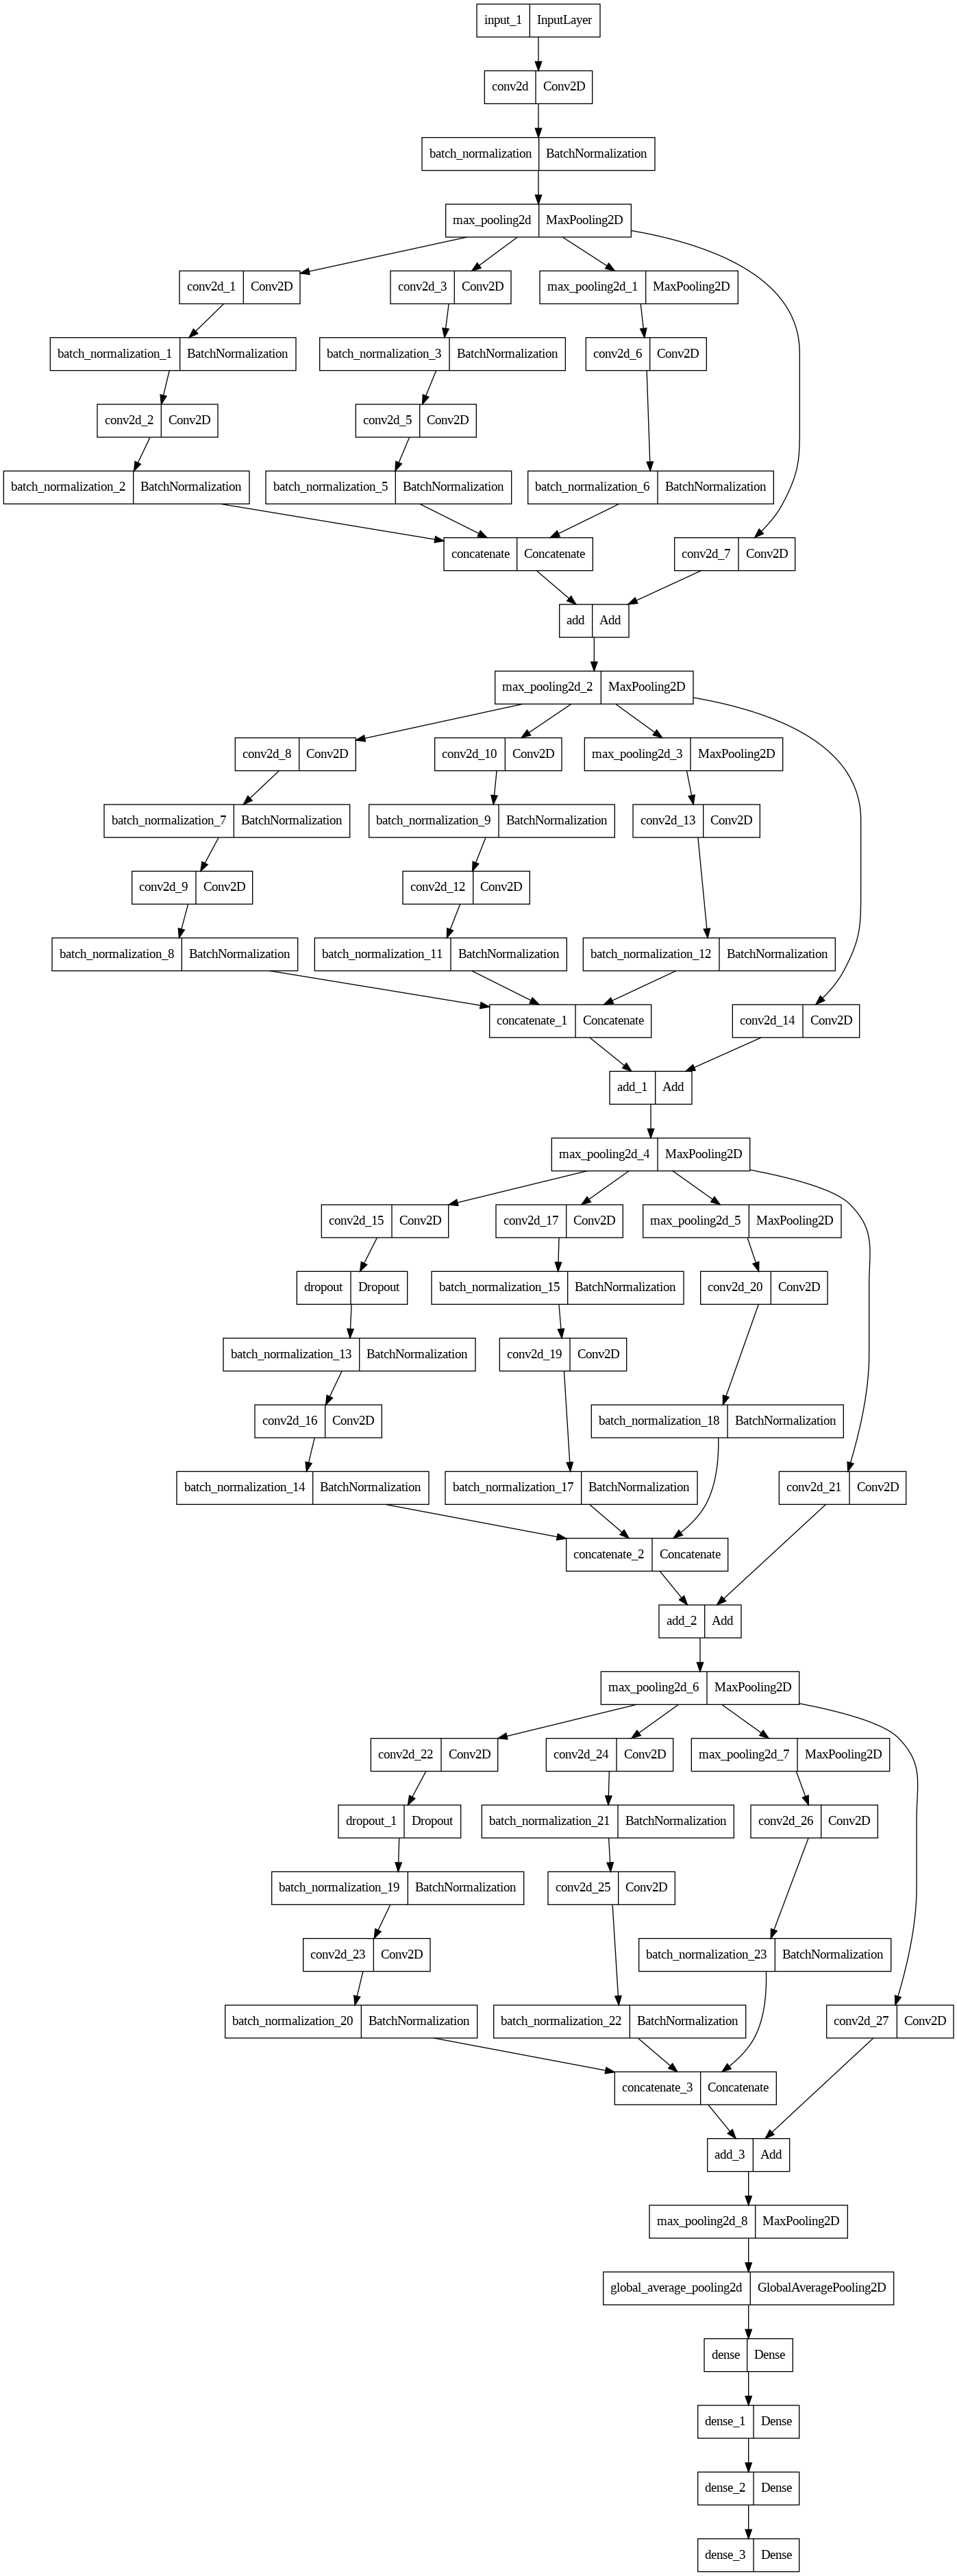

In [20]:
 plot_model(model)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [22]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [23]:
gc.collect()

19469

In [24]:
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

train_datagen.fit(x_train)
test_datagen = ImageDataGenerator()
test_datagen.fit(x_test)

In [25]:

es = EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True)



reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=.1, patience=4, min_lr=1e-6)

In [26]:
batch_size = 128
epochs = 60
history = model.fit(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = test_datagen.flow(x_test, y_test),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                              validation_steps=(x_test.shape[0] // batch_size),
                    callbacks=[reduce_lr])


Epoch 1/60
67/67 [==============================] - 87s 714ms/step - loss: 2.3566 - accuracy: 0.2575 - val_loss: 2.8859 - val_accuracy: 0.0804 - lr: 0.0010
Epoch 2/60
67/67 [==============================] - 45s 669ms/step - loss: 1.8853 - accuracy: 0.3383 - val_loss: 3.2554 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/60
67/67 [==============================] - 44s 672ms/step - loss: 1.8377 - accuracy: 0.3521 - val_loss: 2.7877 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 4/60
67/67 [==============================] - 46s 674ms/step - loss: 1.7087 - accuracy: 0.4027 - val_loss: 3.2897 - val_accuracy: 0.0804 - lr: 0.0010
Epoch 5/60
67/67 [==============================] - 45s 674ms/step - loss: 1.6451 - accuracy: 0.4257 - val_loss: 2.6227 - val_accuracy: 0.1830 - lr: 0.0010
Epoch 6/60
67/67 [==============================] - 45s 664ms/step - loss: 1.6093 - accuracy: 0.4356 - val_loss: 2.2306 - val_accuracy: 0.2433 - lr: 0.0010
Epoch 7/60
67/67 [==============================] - 46s 676ms/st

In [27]:
print("Model Performance on test set")
result = model.evaluate(x_test,y_test)
print(dict(zip(model.metrics_names, result)))

Model Performance on test set
60/60 [==============================] - 4s 62ms/step - loss: 1.2554 - accuracy: 0.6130
{'loss': 1.25539231300354, 'accuracy': 0.6129707098007202}


In [28]:
def plot_graph(history,string):
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show

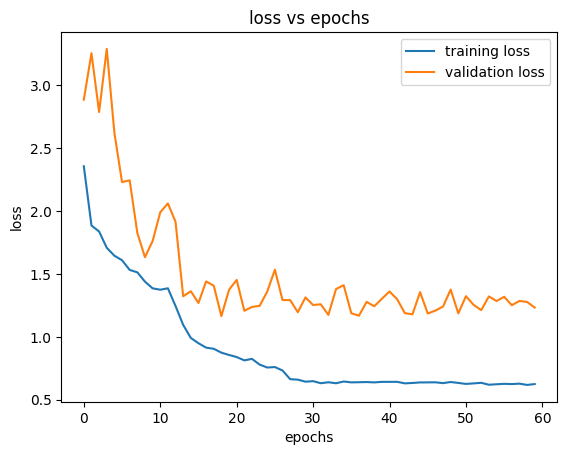

In [33]:
plot_graph(history,'loss')

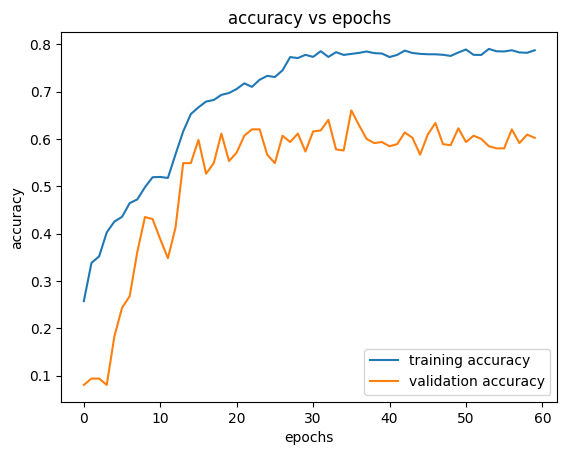

In [34]:
plot_graph(history,'accuracy')

In [31]:
model.save('model.h5')

In [32]:
from keras.models import load_model
import cv2
import numpy as np
import os
from tqdm import tqdm
import json
from google.colab import drive
drive.mount('/content/drive')
test_dir = '/content/drive/MyDrive/test/test/anonymous'

model = load_model('model.h5',compile=False)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

IMG_SIZE = 128

map_output = {0: 'jullienne',
1: 'whole',
2: 'diced',
3: 'floured',
4: 'grated',
5: 'peeled',
6: 'sliced',
7: 'mixed',
8: 'other',
9: 'juiced',
10: 'creamy_paste'}


def predict(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.array(img).reshape(-1, IMG_SIZE, IMG_SIZE, 3)/255.0
    result = model.predict(img)
    return map_output[np.argmax(result)]


outputs = {}
for image in tqdm(os.listdir(test_dir)):
    full_path = os.path.join(test_dir,image)
    outputs[image] = predict(full_path)

with open("prediction.json", "w") as outfile:
    json.dump(outputs, outfile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 1s 986ms/step


  0%|          | 1/500 [00:01<10:44,  1.29s/it]

1/1 [==============================] - 0s 22ms/step


  0%|          | 2/500 [00:01<05:55,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 3/500 [00:01<04:19,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 4/500 [00:02<03:35,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 5/500 [00:02<03:10,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 6/500 [00:06<14:08,  1.72s/it]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 7/500 [00:06<09:46,  1.19s/it]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 9/500 [00:07<05:26,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 11/500 [00:07<03:32,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 12/500 [00:07<02:56,  2.76it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 14/500 [00:07<02:04,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 16/500 [00:07<01:36,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 18/500 [00:07<01:19,  6.08it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 20/500 [00:08<01:07,  7.08it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 22/500 [00:08<01:00,  7.94it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 24/500 [00:08<00:56,  8.45it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 26/500 [00:08<00:53,  8.88it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 28/500 [00:08<00:48,  9.82it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 30/500 [00:09<00:43, 10.91it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 32/500 [00:09<00:39, 11.76it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 34/500 [00:09<00:38, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 36/500 [00:09<00:37, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 38/500 [00:09<00:36, 12.67it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 40/500 [00:09<00:35, 12.83it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 42/500 [00:09<00:35, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 44/500 [00:10<00:34, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 46/500 [00:10<00:34, 13.32it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 48/500 [00:10<00:33, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 50/500 [00:10<00:32, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 52/500 [00:10<00:32, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 54/500 [00:10<00:33, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 56/500 [00:10<00:32, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 58/500 [00:11<00:32, 13.56it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 60/500 [00:11<00:31, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 62/500 [00:11<00:30, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 64/500 [00:11<00:30, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 66/500 [00:11<00:29, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 68/500 [00:11<00:30, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 70/500 [00:11<00:28, 14.89it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 72/500 [00:12<00:29, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 74/500 [00:12<00:28, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 76/500 [00:12<00:27, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 78/500 [00:12<00:28, 15.06it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 80/500 [00:12<00:27, 15.03it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 82/500 [00:12<00:28, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 84/500 [00:12<00:28, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 86/500 [00:13<00:28, 14.51it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 88/500 [00:13<00:28, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 90/500 [00:13<00:28, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 92/500 [00:13<00:27, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 94/500 [00:13<00:28, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 96/500 [00:13<00:28, 14.27it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 98/500 [00:13<00:29, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 100/500 [00:14<00:29, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 102/500 [00:14<00:29, 13.63it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 104/500 [00:14<00:27, 14.17it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 106/500 [00:14<00:27, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 108/500 [00:14<00:27, 14.38it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 110/500 [00:14<00:26, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 112/500 [00:14<00:26, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 114/500 [00:14<00:26, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 116/500 [00:15<00:26, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 118/500 [00:15<00:26, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 120/500 [00:15<00:27, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 122/500 [00:15<00:26, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 124/500 [00:15<00:26, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 126/500 [00:15<00:26, 14.23it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 128/500 [00:15<00:26, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 130/500 [00:16<00:25, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 132/500 [00:16<00:26, 13.90it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 134/500 [00:16<00:26, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 136/500 [00:16<00:27, 13.08it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 138/500 [00:16<00:27, 13.39it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 140/500 [00:16<00:26, 13.74it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 142/500 [00:16<00:25, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 144/500 [00:17<00:25, 13.95it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 146/500 [00:17<00:25, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 148/500 [00:17<00:24, 14.32it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 150/500 [00:17<00:24, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 152/500 [00:17<00:23, 14.65it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 154/500 [00:17<00:24, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 156/500 [00:17<00:23, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 158/500 [00:18<00:24, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 160/500 [00:18<00:24, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 162/500 [00:18<00:24, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 164/500 [00:18<00:23, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 166/500 [00:18<00:23, 14.04it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 168/500 [00:18<00:24, 13.34it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 170/500 [00:19<00:26, 12.31it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 172/500 [00:19<00:29, 11.28it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 174/500 [00:19<00:29, 11.04it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 176/500 [00:19<00:29, 10.91it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 178/500 [00:19<00:29, 10.97it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 180/500 [00:19<00:29, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 182/500 [00:20<00:29, 10.72it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 184/500 [00:20<00:29, 10.89it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 186/500 [00:20<00:28, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 188/500 [00:20<00:28, 10.84it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 190/500 [00:20<00:29, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 192/500 [00:21<00:29, 10.47it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 194/500 [00:21<00:29, 10.52it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 196/500 [00:21<00:29, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 198/500 [00:21<00:29, 10.31it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 200/500 [00:21<00:28, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 202/500 [00:22<00:28, 10.42it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 204/500 [00:22<00:28, 10.53it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 206/500 [00:22<00:27, 10.69it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 208/500 [00:22<00:25, 11.42it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 210/500 [00:22<00:23, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 212/500 [00:22<00:22, 12.63it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 214/500 [00:23<00:21, 13.03it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 216/500 [00:23<00:22, 12.71it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 218/500 [00:23<00:20, 13.46it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 220/500 [00:23<00:20, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 222/500 [00:23<00:19, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 224/500 [00:23<00:20, 13.60it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 226/500 [00:23<00:20, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 228/500 [00:24<00:19, 13.86it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 230/500 [00:24<00:19, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 232/500 [00:24<00:19, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 234/500 [00:24<00:18, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 236/500 [00:24<00:18, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 238/500 [00:24<00:19, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 240/500 [00:24<00:18, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 242/500 [00:25<00:18, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 244/500 [00:25<00:18, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 246/500 [00:25<00:18, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 248/500 [00:25<00:17, 14.17it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 250/500 [00:25<00:17, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 252/500 [00:25<00:17, 14.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 254/500 [00:25<00:17, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 256/500 [00:26<00:17, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 258/500 [00:26<00:17, 13.91it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 260/500 [00:26<00:16, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 262/500 [00:26<00:16, 14.21it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 264/500 [00:26<00:16, 14.28it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 266/500 [00:26<00:16, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 268/500 [00:26<00:15, 14.58it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 270/500 [00:27<00:15, 14.56it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 272/500 [00:27<00:16, 13.70it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 274/500 [00:27<00:16, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 276/500 [00:27<00:15, 14.47it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 278/500 [00:27<00:16, 13.42it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 280/500 [00:27<00:15, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 282/500 [00:27<00:16, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 284/500 [00:28<00:15, 13.81it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 286/500 [00:28<00:15, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 288/500 [00:28<00:15, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 290/500 [00:28<00:15, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 292/500 [00:28<00:15, 13.31it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 294/500 [00:28<00:14, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 296/500 [00:28<00:14, 13.73it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 298/500 [00:29<00:14, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 300/500 [00:29<00:14, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 302/500 [00:29<00:13, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 304/500 [00:29<00:13, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 306/500 [00:29<00:13, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 308/500 [00:29<00:13, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 310/500 [00:29<00:13, 14.32it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 312/500 [00:30<00:13, 14.28it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 314/500 [00:30<00:13, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 316/500 [00:30<00:13, 13.64it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 318/500 [00:30<00:12, 14.04it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 320/500 [00:30<00:12, 14.34it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 322/500 [00:30<00:12, 13.89it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 324/500 [00:30<00:12, 14.00it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 326/500 [00:31<00:12, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 328/500 [00:31<00:11, 14.39it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 330/500 [00:31<00:11, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 332/500 [00:31<00:11, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 334/500 [00:31<00:11, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 336/500 [00:31<00:11, 14.51it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 338/500 [00:31<00:10, 14.81it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 340/500 [00:31<00:10, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 342/500 [00:32<00:10, 14.50it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 344/500 [00:32<00:10, 14.47it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 346/500 [00:32<00:11, 13.52it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 348/500 [00:32<00:12, 11.85it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 350/500 [00:32<00:13, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 352/500 [00:33<00:13, 10.89it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 354/500 [00:33<00:13, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 356/500 [00:33<00:13, 10.58it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 358/500 [00:33<00:13, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 360/500 [00:33<00:13, 10.17it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 362/500 [00:34<00:13, 10.30it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 364/500 [00:34<00:12, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 366/500 [00:34<00:12, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 368/500 [00:34<00:12, 10.42it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 370/500 [00:34<00:12, 10.61it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 372/500 [00:35<00:12, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 374/500 [00:35<00:12, 10.24it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 376/500 [00:35<00:12,  9.77it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 377/500 [00:35<00:12,  9.74it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 379/500 [00:35<00:11, 10.09it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 381/500 [00:35<00:11, 10.29it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 383/500 [00:36<00:11, 10.19it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 385/500 [00:36<00:10, 10.82it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 387/500 [00:36<00:10, 11.03it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 389/500 [00:36<00:09, 11.81it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 391/500 [00:36<00:08, 12.32it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 393/500 [00:36<00:08, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 395/500 [00:37<00:08, 12.48it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 397/500 [00:37<00:07, 12.92it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 399/500 [00:37<00:07, 13.45it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 401/500 [00:37<00:07, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 403/500 [00:37<00:07, 13.46it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 405/500 [00:37<00:06, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 407/500 [00:37<00:06, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 409/500 [00:38<00:06, 13.73it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 411/500 [00:38<00:06, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 413/500 [00:38<00:06, 13.31it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 415/500 [00:38<00:06, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 417/500 [00:38<00:06, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 419/500 [00:38<00:05, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 421/500 [00:38<00:05, 13.26it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 423/500 [00:39<00:05, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 425/500 [00:39<00:05, 13.69it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 427/500 [00:39<00:05, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 429/500 [00:39<00:05, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 431/500 [00:39<00:04, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 433/500 [00:39<00:04, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 435/500 [00:39<00:04, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 437/500 [00:40<00:04, 14.05it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 439/500 [00:40<00:04, 13.24it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 441/500 [00:40<00:04, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 443/500 [00:40<00:04, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 445/500 [00:40<00:04, 12.86it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 447/500 [00:40<00:04, 13.18it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 449/500 [00:41<00:03, 13.28it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 451/500 [00:41<00:03, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 453/500 [00:41<00:03, 13.79it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 455/500 [00:41<00:03, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 457/500 [00:41<00:03, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 459/500 [00:41<00:03, 13.36it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 461/500 [00:41<00:02, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 463/500 [00:42<00:02, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 465/500 [00:42<00:02, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 467/500 [00:42<00:02, 13.59it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 469/500 [00:42<00:02, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 471/500 [00:42<00:02, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 473/500 [00:42<00:02, 13.23it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 475/500 [00:42<00:01, 12.84it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 477/500 [00:43<00:01, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 479/500 [00:43<00:01, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 481/500 [00:43<00:01, 13.17it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 483/500 [00:43<00:01, 13.03it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 485/500 [00:43<00:01, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 487/500 [00:43<00:01, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 489/500 [00:44<00:00, 13.16it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 491/500 [00:44<00:00, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 493/500 [00:44<00:00, 13.29it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 495/500 [00:44<00:00, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 497/500 [00:44<00:00, 13.00it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 499/500 [00:44<00:00, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 500/500 [00:44<00:00, 11.15it/s]
